#Mine the Gap: Micro-Targeting Patients for Care Coordination & Social Support Services

####Ceslee Montgomery
####July 9, 2015

##Motivation

<img src=http://www.telecarecorp.com/images/medialibrary/1398120631226.jpg>

- [1] One of the ways healthcare is fundamentally broken is lack of tools to help care providers get a "360 view" of their patients complex socioeconomic, psychosocial, and cultural circumstances in order to provide them patient-centered, quality, timely, and relevant care.


- [2] Why this is bad: 1) Providers often can't address the root problem. 2) Take a step back. Where's the compassion when you see disease and not a complex human being?  


- [3] Why are we treating diseases instead of people who are sick? Addressing not just the medical conditions that present themselves on the surface (with pharmaceutical drugs and quick fixes), but the complex root causes.  


- [4] Perhaps most fundamentaly, when we just address the surface, and don't take the time and care to address complex concerns, how is that compassionate care?  


- [5] Doctors/nurses often operate without knowledge of the full complexity of these patients needs and what goes on outside the four walls of their doctor's office.  


- And you might wonder what's the impetus for change?  Well with the recent healthcare legislation our country is moving towards a value-based payment model.  


- If patient's don't get better, you don't get paid.  So it behooves you to have access to the full picture and not just what happens in the four walls of your doctors office. 


- For me this is a test, an experiment that's part of the bigger problem of leveraging the same technology that's propelling people like Uber to be a trillion dollar company, to see if data science can create new products and services to better serve these people, or for that matter all people. 

##Problem

- What can interesting and non-obvious insights can we learn about the patients we serve?


- From a patient's perspective, where are the gaps in care?


- Ultimately, where are the opportunities for improved system management for most at-risk enrollees?


##Goal

- Segment Population
- Segment Profile Analysis
- Segment Feature Analysis

- Goal here is to gain deeper insight into a population.  
- Identify important characteristics that might give us clues about behaviors, preferences, and context for their particular needs.
- Along the way we're going to learn interesting things about factors associated poor good health status, pain, mental health and physical health.

##The Data

###[2013 HOS Survey](hosonline.org)
- Medicare Population Survey
    - a broad assessment of physical and mental health functioning of Medicare beneficiaries
    - consists of several surveys (VR12, HEDIS Quality of Care, etc)
    - 83 fields

###The Final Dataset
- 10K Record sample from 303K total
- broke this into 4 domains
    - Demographic Profile
    - Disease Profile
    - Wellness Profile
    - Needs Profile

#Model Selection

- Micro-Segmenting Populations is an Unsupervised Problem: so, Clustering. 
- Why Clustering?
 - Well-studied machine learning task: grouping objects so that objects in groups are more similar than those in others.  Then, generalize from groups.
 - Used in marketing to personalize marketing, develop new services product offerings.

#####As you recall this is how it works:
1. Choose k-initial centroids
2. For each point: (a) distance to centroid, (b) assign point to nearest centroid
3. Recalculate centroid positions
4. Repeat steps 2-3 until stopping criteria are met.

#####This is how we measure success:


<br>
**Sum of Squared Errors Definition:**

$$
SSE = \displaystyle\sum_{i=1}^{K}\sum_{x \in C_i} d(x, c_i)^2
$$

**Silhouette Coefficient Definition:**

$$
SC_{total} = 1/k \displaystyle\sum_{1}^{k}SC(C_{i})
$$

In [1]:
# import warnings
# warnings.filterwarnings('ignore')
import os.path

%matplotlib inline

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

sns.set(style="darkgrid")
plt.style.use('ggplot')

SOURCE_DATA_PATH = 'source_data'
DERIVED_DATA_PATH = 'derived_data'

In [4]:
needs = pd.read_csv(os.path.join(DERIVED_DATA_PATH,'C16B_PUF_cleaned_needs.csv'), na_values=' ', index_col='ID')
wellness = pd.read_csv(os.path.join(DERIVED_DATA_PATH,'C16B_PUF_cleaned_wellness.csv'), na_values=' ', index_col='ID')

km_X = needs.join(wellness).dropna() 

In [5]:
print 'data retention post-drop: {:.2%} percent.'.format(float(len(km_X))/len(needs))
print '# records retention post-drop: {}'.format(len(km_X))

data retention post-drop: 69.73% percent.
# records retention post-drop: 211646


So that's not bad.  Let's keep going with our cluster analysis by building our model.

##Build Model

#####Overview:
- Train on wellness + needs data, investigate demographic profiles, and evaluate features importance.

#####Plan:
- Choose K
- Fit data to optimal K
- Proceed with analyzing our cohorts.

In [6]:
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.metrics import pairwise_distances

Now implementation...

In [7]:
#SSE get_cluster_centers helper function
def get_cluster_centers(X, labels, k_num):
    CC_list = []
    for k in range(k_num):
        #get mean coordinates of each cluster
        CC_list.append(np.mean(X[labels ==k], axis=0))
    return CC_list

#main SSE function
#for each cluster subtract the mean from each data point to get the error
#then get the magnitude of each error, square it, and sum it
def get_SSE(X, labels):
    k_num = len(np.unique(labels))
    CC_list = get_cluster_centers(X,labels, k_num)
    CSEs = []
    for k in range(k_num):
        # for each cluster of k we get the coordinates of how far off each point is to the cluster
        error_cords = X[labels == k] - CC_list[k]
        # square the coordinates and sum to get the magnitude squared
        error_cords_sq = error_cords ** 2
        error_mag_sq = np.sum(error_cords_sq, axis = 1)
        CSE = np.sum(error_mag_sq)
        CSEs.append(CSE)
    # sum each cluster's sum of squared errors
    return sum(CSEs)   

In [8]:
km_X = km_X.sample(n=10000, random_state=1)

In [11]:
k_range = range(2,10)

Here we'll run "k_range" models with k clusters.

In [15]:
# %%timeit

SSEs = []
Sil_coefs = []

for k in k_range:
    #instantiate KMeans object
    km = KMeans(n_clusters=k, random_state=1)
    #fit model to training data
    km.fit(km_X)
    labels = km.labels_
    #store SC & SSE scores for each k run
    Sil_coefs.append(metrics.silhouette_score(km_X, labels, metric='euclidean'))
    SSEs.append(get_SSE(km_X, labels))


It'll make most sense for us to run the model over several k's to arrive at the optimal k for our data.  To evaluate cluster validity we're going to consider two metrics: the Silhouette Coefficient & our old friend Sum of Squared Errors.  We don't get SSE out of the box with sklearn so we'll write our own.  Let's do that first.

##Evaluate Model

Let's plot the SSE and SC to see where our optimum k lies.

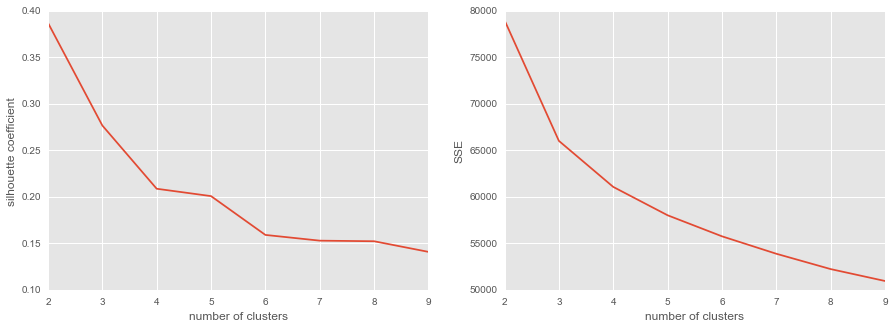

In [18]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,5), sharex=True)
ax1.plot(k_range, Sil_coefs)
ax1.set_xlabel('number of clusters')
ax1.set_ylabel('silhouette coefficient')

# plot here on ax2
ax2.plot(k_range, SSEs)
ax2.set_xlabel('number of clusters')
ax2.set_ylabel('SSE');

On interpreting the Average Silhouette Coefficient from [sckit-learn.org](http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html): 
> Silhoette coefficients (as these values are referred to as) near +1 indicate that the sample is far away from the neighboring clusters. A value of 0 indicates that the sample is on or very close to the decision boundary between two neighboring clusters and negative values indicate that those samples might have been assigned to the wrong cluster.

- SC closest to 1
- SSE minimized, trouble is greater k harder it is for humans to make sense, greatest decrease SSE per step is from 2 to 3 so I'm leaning towards 2 or 3.

What we can do is visualize a PCA-reduced 2-dim plot of our clustering job to see if that will help us make a final call.

In [22]:
#helper function first
def show_kmeans_plot(fig_num, k, reduced_data):
    kmeans = KMeans(init='k-means++', n_clusters=k, n_init=10)
    kmeans.fit(reduced_data)
    # Step size of the mesh. Decrease to increase the quality of the VQ.
    h = .02     # point in the mesh [x_min, m_max]x[y_min, y_max].

    # Plot the decision boundary. For that, we will assign a color to each
    x_min, x_max = reduced_data[:, 0].min() + 1, reduced_data[:, 0].max() - 1
    y_min, y_max = reduced_data[:, 1].min() + 1, reduced_data[:, 1].max() - 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    # Obtain labels for each point in mesh. Use last trained model.
    Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.figure(fig_num)
    plt.clf()
    plt.imshow(Z, interpolation='nearest',
               extent=(xx.min(), xx.max(), yy.min(), yy.max()),
               cmap=plt.cm.Paired,
               aspect='auto', origin='lower')

    plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=2)
    # Plot the centroids as a white X
    centroids = kmeans.cluster_centers_
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=169, linewidths=3,
                color='w', zorder=10)
    plt.title('K-means clustering on PCA-reduced data where k = {}\n'
              'Centroids are marked with white cross'.format(k))
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.xticks(())
    plt.yticks(())
    return plt

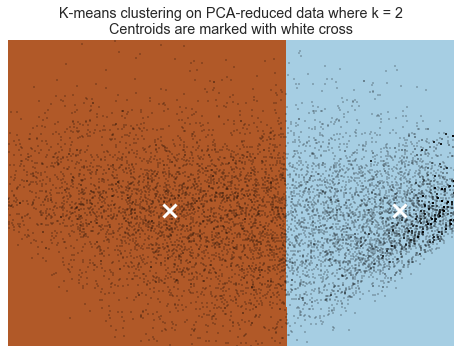

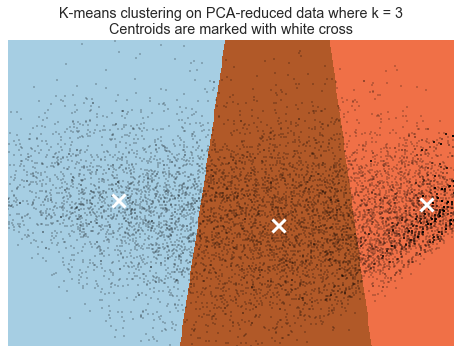

In [23]:
# Visualize the results on PCA-reduced data
from sklearn.decomposition import PCA

reduced_data = PCA(n_components=2).fit_transform(km_X)

ax1 = show_kmeans_plot(1, 2, reduced_data)
ax2 = show_kmeans_plot(2, 3, reduced_data)


The visual analysis here and the SC evaluation seems to support the existence of two clusters, but let's kick the can down the road and see what happens when we use try both. 

In [24]:
cols = {}

for k in [2,3]:
    #instantiate KMeans model
    km = KMeans(n_clusters=k, random_state=1)
    #fit model to training data
    km.fit(km_X)
    col_name = 'segment_k_' + str(k)
    #predict classes for km_X
    #new df from index + predicted class
    cols[col_name] = km.predict(km_X)

km_index = km_X.index.values.tolist()
ID_to_kmsegment = pd.DataFrame(cols, index=km_index)    

To keep track of beneficiary segment membership I've just made a little key for later analysis.  Each record included in clustering (aka was not na/dropped) corresponds to a k=2 cluster and a k=3 cluster.

In [25]:
ID_to_kmsegment.head(2)

segment_k_2  segment_k_3
C16267634            1            2
C16194877            0            0

##Segment Profile Analysis

Now let's take a look at how the demographics between our clusters vary to get some kind of intuition about how the model has segmented our beneficiary population.  
<br>Here we'll load in our patient profiles and join in their segment membership.

In [26]:
profile = pd.read_csv(os.path.join(DERIVED_DATA_PATH,'C16B_PUF_cleaned_profile.csv'), na_values=' ', index_col='ID')
profile_seg = pd.concat([profile, ID_to_kmsegment], axis=1, join='inner')
profile_seg.head(1)

AGE   RACE GENDER MARITALSTAT            EDUCATION  \
C16267634  65 to 74  White      M     Married  Greater than HS/GED   

                       REGION LANGUAGE                 OBESE  SMOKER  \
C16267634  Region 5 (Chicago)  English  Not obese (BMI < 30)       0   

           DEPRESSION  MCC AT-RISK CC-NEED  segment_k_2  segment_k_3  
C16267634           1    4    True    True            1            2

In [27]:
#Build y = % of segment to evaluate relative frequency.
seg1_total = 1.0/len(profile_seg[profile_seg['segment_k_2'] == 0])
seg2_total = 1.0/len(profile_seg[profile_seg['segment_k_2'] == 1])
profile_seg['calc_percent'] = profile_seg['segment_k_2'].apply(lambda x: seg1_total if x == 0 else seg2_total)
sum_function = lambda x: sum(x)

###Demographic Differences

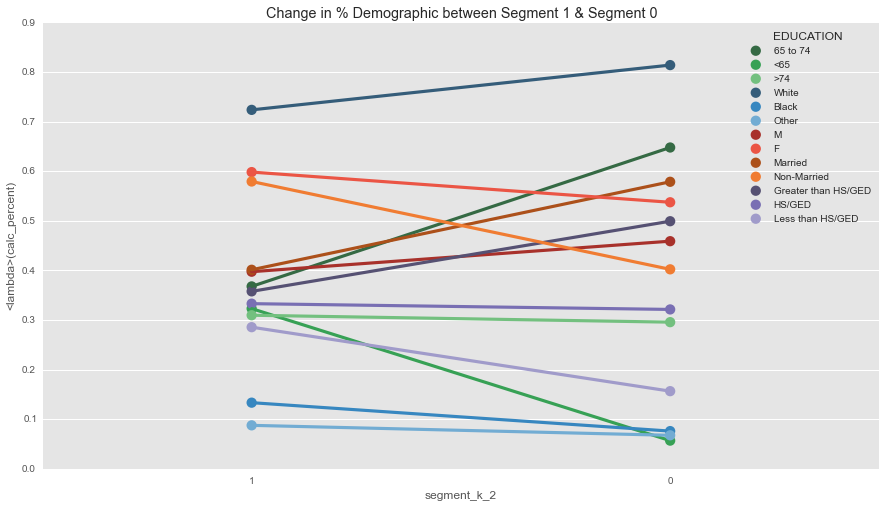

In [59]:
fig = plt.subplots(1,1, sharey=True, figsize=(15,8))

sns.pointplot(estimator=sum_function, x='segment_k_2', y='calc_percent', hue='AGE', data=profile_seg, palette="Greens_d").set_title('Change in % Demographic between Segment 1 & Segment 0');
sns.pointplot(estimator=sum_function, x='segment_k_2', y='calc_percent', hue='RACE', data=profile_seg, palette="Blues_d");
sns.pointplot(estimator=sum_function, x='segment_k_2', y='calc_percent', hue='GENDER', data=profile_seg, palette="Reds_d");
sns.pointplot(estimator=sum_function, x='segment_k_2', y='calc_percent', hue='MARITALSTAT', data=profile_seg, palette="Oranges_d");
sns.pointplot(estimator=sum_function, x='segment_k_2', y='calc_percent', hue='EDUCATION', data=profile_seg, palette="Purples_d");

What's nice about this plot is it gives us two pieces of information: % Demographic for each segment and the % change between segment 1 and segment 2.  

<br>So for example, **Segment 1** seems to have a greater relative percentage of **<65 year olds, non-married individuals, and slighlty more women**.  **Segment 2** seems to have a greater relative percentage of **65 to 74 year olds, Whites, and individuals with greater than a HS/GED.**  Don't worry though... we're going to perform some statistical tests to see if our observed differences are actually significant.  Let's take a gander at a contingency table to see if any differences between groups are significant.

Two things you should take away:
    1. Homogenous vs. Heterogeneous
    2. Differences among groups?
    
- Take for example, (1) white, (2) Greater than HS, Unmarried
- Overall, visually appear to see some differences.

In [41]:
#Handy reusable draw chart function
import scipy.stats as sps

class ListTable(list):
        """ Overridden list class which takes a 2-dimensional list of 
            the form [[1,2,3],[4,5,6]], and renders an HTML Table in 
            IPython Notebook. """

        def _repr_html_(self):
            html = ["<table>"]
            for row in self:
                html.append("<tr>")

                for col in row:
                    html.append("<td>{0}</td>".format(col))

                html.append("</tr>")
            html.append("</table>")
            return ''.join(html)

def get_chi(col):
    obs_freq_vals = (profile_seg.groupby('segment_k_2')[col].value_counts().unstack().T).values
    chi2, p, dof, expected = sps.chi2_contingency(obs_freq_vals)
    return chi2, p

def draw_table(column_names):  
    table = ListTable()
    table.append(['Demographic Characteristics', 'X^2 (p)', 'Segment 1(%)', 'Segment 0 (%)', 'Odds Ratio'])

    for col in column_names:
        #make pivot table
        tab = profile_seg.pivot_table(values='calc_percent', index='segment_k_2', columns=[col], aggfunc='sum').transpose()
        #extract column name, index, and values
        idx = list(tab.index)
        perc_demog = tab.values
        #find chisq and p value
        chi2, pval = get_chi(col)
        chi2_p = '{:.1f} ({:.2E})'.format(chi2, pval)
        #append to table
        for e, i in enumerate(idx):
            if e == 0:
                table.append([col, chi2_p, '', '', ''])
            odds_ratio = (perc_demog[e][1] / float(1- perc_demog[e][1])) / (perc_demog[e][0] / float(1- perc_demog[e][0]))
            table.append([i, '', '{:.1f}'.format(perc_demog[e][1]*100), '{:.1f}'.format(perc_demog[e][0]*100), '{:.1f}'.format(odds_ratio)])
    return table

In [43]:
#for each column of interest
demog_cols = list(profile_seg.columns[:5])
draw_table(demog_cols)

[['Demographic Characteristics',
  'X^2 (p)',
  'Segment 1(%)',
  'Segment 0 (%)',
  'Odds Ratio'],
 ['AGE', '1390.2 (1.32E-302)', '', '', ''],
 ['65 to 74', '', '36.8', '64.8', '0.3'],
 ['<65', '', '32.3', '5.7', '7.9'],
 ['>74', '', '31.0', '29.6', '1.1'],
 ['RACE', '118.1 (2.27E-26)', '', '', ''],
 ['Black', '', '13.3', '7.6', '1.9'],
 ['Other', '', '8.8', '6.7', '1.3'],
 ['White', '', '72.4', '81.4', '0.6'],
 ['GENDER', '36.8 (1.29E-09)', '', '', ''],
 ['F', '', '59.8', '53.7', '1.3'],
 ['M', '', '39.7', '45.9', '0.8'],
 ['MARITALSTAT', '309.9 (2.35E-69)', '', '', ''],
 ['Married', '', '40.1', '57.9', '0.5'],
 ['Non-Married', '', '57.9', '40.2', '2.0'],
 ['EDUCATION', '303.2 (1.46E-66)', '', '', ''],
 ['Greater than HS/GED', '', '35.8', '49.9', '0.6'],
 ['HS/GED', '', '33.3', '32.1', '1.1'],
 ['Less than HS/GED', '', '28.5', '15.6', '2.2']]

Does anyone know the age requirement for Medicare?
It turns out only under exceptional circumstances can you get Medicare.  1) disability, 2) ESRD, 3) ALS.

In [58]:
#Explore why 8 times more <65
profile_seg.pivot_table(['DEPRESSION', 'MCC', 'SMOKER'], index='AGE')

DEPRESSION       MCC    SMOKER
AGE                                     
65 to 74    0.193603  2.811643  0.122182
<65         0.596725  3.669675  0.304321
>74         0.168957  3.333886  0.049883

###Regional Differences

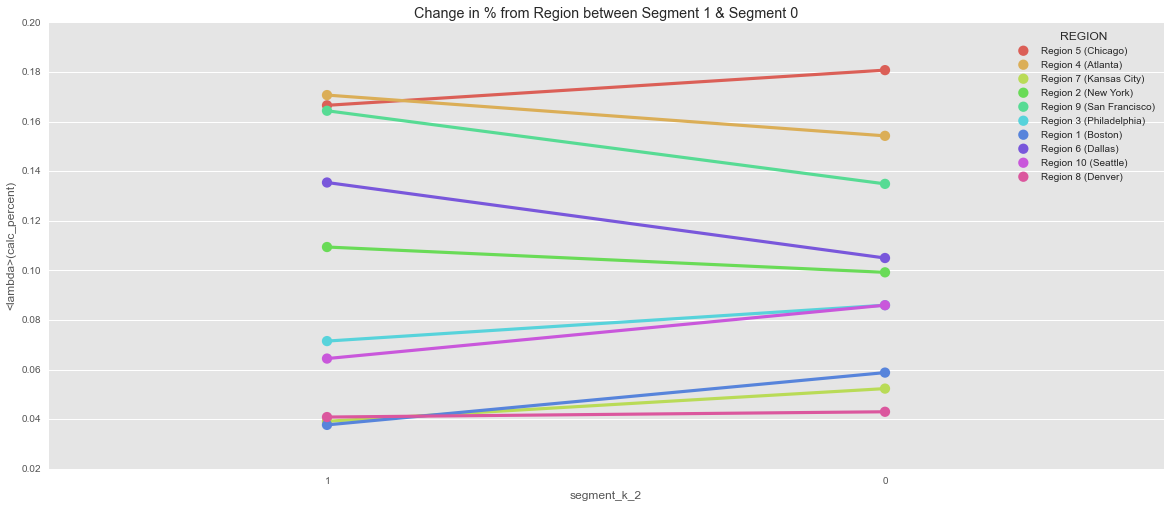

In [60]:
fig_region = plt.subplots(1,1, figsize=(20,8))
sns.pointplot(estimator=sum_function, x='segment_k_2', y='calc_percent', hue='REGION', data=profile_seg, palette="hls").set_title('Change in % from Region between Segment 1 & Segment 0');

In [575]:
#for each column of interest
region_cols = ['REGION']
draw_table(region_cols)

[['Demographic Characteristics',
  'X^2 (p)',
  'Segment 1(%)',
  'Segment 0 (%)',
  'Odds Ratio'],
 ['REGION', '2110.7 (0.00E+00)', '', '', ''],
 ['Region 1 (Boston)', '', '4.1', '6.0', '0.7'],
 ['Region 10 (Seattle)', '', '6.8', '8.4', '0.8'],
 ['Region 2 (New York)', '', '11.1', '9.4', '1.2'],
 ['Region 3 (Philadelphia)', '', '7.3', '8.7', '0.8'],
 ['Region 4 (Atlanta)', '', '16.9', '15.2', '1.1'],
 ['Region 5 (Chicago)', '', '16.1', '18.6', '0.8'],
 ['Region 6 (Dallas)', '', '14.7', '10.6', '1.4'],
 ['Region 7 (Kansas City)', '', '3.9', '5.3', '0.7'],
 ['Region 8 (Denver)', '', '3.9', '4.4', '0.9'],
 ['Region 9 (San Francisco)', '', '15.2', '13.4', '1.2']]

There doesn't seem to be major regional variance.  At most there appears to be 4% difference among a region between the segments.

###Chronic Conditions

	 	 # of Chronic Conditions by Segment


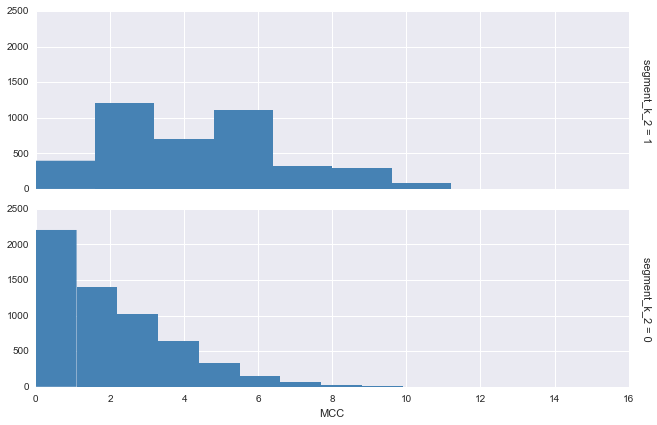

In [157]:
print '\t \t # of Chronic Conditions by Segment'
g = sns.FacetGrid(profile_seg, aspect=3, row='segment_k_2', margin_titles=True);
g.map(plt.hist, 'MCC', color="steelblue", lw=0);

###Disease Indicators

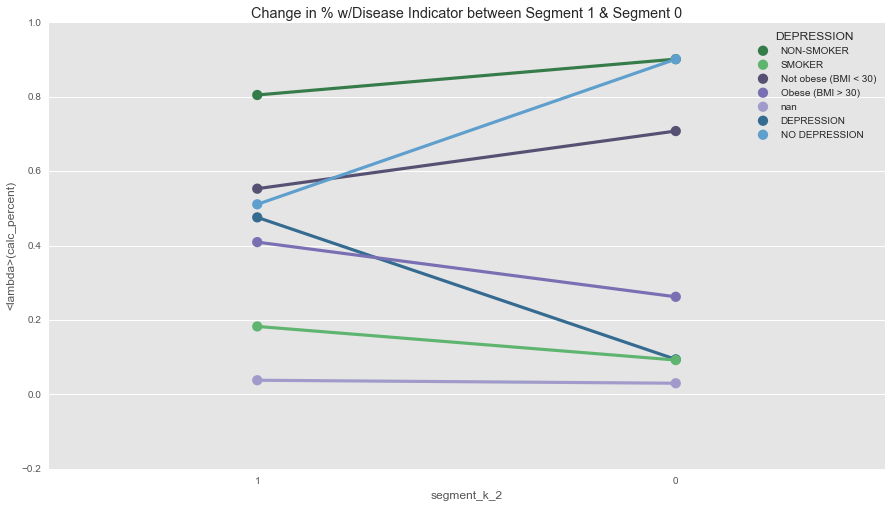

In [139]:
fig2 = plt.subplots(1,1, sharey=True, figsize=(15,8))

profile_seg.replace({
        'SMOKER':{0:'NON-SMOKER', 1:'SMOKER'},
        'DEPRESSION':{0:'NO DEPRESSION',1:'DEPRESSION'},
        'AT-RISK':{False:'NOT AT-RISK', True:'AT-RISK'},
        'CC-NEED':{False:'NO CC-NEEDED', True:'CC-NEEDED'}
    }, inplace=True)

profile_seg['OBESE'] = profile_seg['OBESE'].map(lambda x: str(x).decode('utf-8').strip())

sns.pointplot(estimator=sum_function, x='segment_k_2', y='calc_percent', hue='SMOKER', data=profile_seg, palette="Greens_d").set_title('Change in % w/Disease Indicator between Segment 1 & Segment 0');
sns.pointplot(estimator=sum_function, x='segment_k_2', y='calc_percent', hue='OBESE', data=profile_seg, palette="Purples_d");
sns.pointplot(estimator=sum_function, x='segment_k_2', y='calc_percent', hue='DEPRESSION', data=profile_seg, palette="Blues_d");



In [63]:
#@CEslee: depression table
#for each column of interest
disease_indicators_cols = list(profile_seg.columns[7:10])
draw_table(disease_indicators_cols)

[['Demographic Characteristics',
  'X^2 (p)',
  'Segment 1(%)',
  'Segment 0 (%)',
  'Odds Ratio'],
 ['OBESE', '256.9 (1.62E-56)', '', '', ''],
 [u'Not obese (BMI < 30)', '', '55.3', '70.8', '0.5'],
 [u'Obese (BMI > 30)', '', '40.9', '26.2', '1.9'],
 [u'nan', '', '3.8', '3.0', '1.3'],
 ['SMOKER', '178.2 (1.22E-40)', '', '', ''],
 ['NON-SMOKER', '', '80.5', '90.1', '0.5'],
 ['SMOKER', '', '18.3', '9.2', '2.2'],
 ['DEPRESSION', '1903.3 (0.00E+00)', '', '', ''],
 ['DEPRESSION', '', '47.6', '9.4', '8.7'],
 ['NO DEPRESSION', '', '51.1', '90.1', '0.1']]

###And Finally..."Gold Standard" Targets

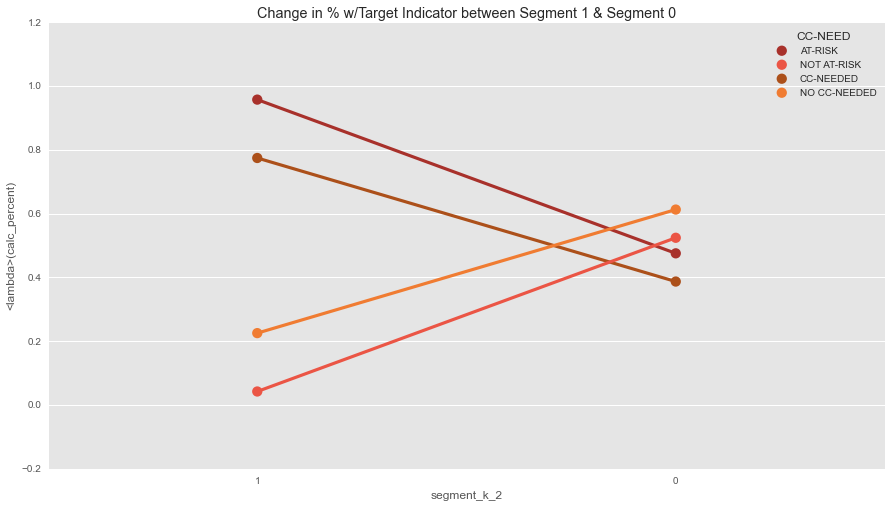

In [62]:
fig3 = plt.subplots(1,1, sharey=True, figsize=(15,8))
sns.pointplot(estimator=sum_function, x='segment_k_2', y='calc_percent', hue='AT-RISK', data=profile_seg, palette="Reds_d").set_title('Change in % w/Target Indicator between Segment 1 & Segment 0');
sns.pointplot(estimator=sum_function, x='segment_k_2', y='calc_percent', hue='CC-NEED', data=profile_seg, palette="Oranges_d");

There's no doubt a latent correlation here between disease indicators and having higher gaps in your wellness profile and needs profile.  We'll explore those next.

From these preliminary results its interesting that CC-NEED, AT-RISK, DEPRESSION, and to a lesser extent SMOKING and OBESITY seem to show a similarly proportionate bias towards segment 1.  

In [579]:
#for each column of interest
targets_cols = list(profile_seg.columns[11:13])
draw_table(targets_cols)

[['Demographic Characteristics',
  'X^2 (p)',
  'Segment 1(%)',
  'Segment 0 (%)',
  'Odds Ratio'],
 ['AT-RISK', '51497.8 (0.00E+00)', '', '', ''],
 ['AT-RISK', '', '95.7', '48.6', '23.4'],
 ['NOT AT-RISK', '', '4.3', '51.4', '0.0'],
 ['CC-NEED', '29717.6 (0.00E+00)', '', '', ''],
 ['CC-NEEDED', '', '77.2', '39.2', '5.3'],
 ['NO CC-NEEDED', '', '22.8', '60.8', '0.2']]

Whoa! Segment 1 is 23 times more likely to be At-Risk.  I think we have a name for our first segment now.

##Segment Factor Analysis

In [46]:
needs_wellness_seg = pd.concat([km_X, ID_to_kmsegment], axis=1, join='inner')
needs_wellness_seg.head(1)

FELTNP  FELTSD  PNIACT  SCLACT  DIFBTH  DIFDRS  DIFEAT  DIFCHR  \
ID                                                                          
C16267634       1       1       1       1       1       1       1       1   

           DIFWLK  DIFTOL     ...       Bodily Pain  General Health  Vitality  \
ID                            ...                                               
C16267634       1       1     ...                 5               5         5   

           Social Functioning  Physical Functioning  Role Physical  \
ID                                                                   
C16267634                   3                     2              5   

           Role Emotional  Mental Health  segment_k_2  segment_k_3  
ID                                                                  
C16267634             3.5              3            1            2  

[1 rows x 27 columns]

In [47]:
#Build y = % of segment to evaluate relative frequency.
seg1_total = 1.0/len(profile_seg[profile_seg['segment_k_2'] == 0])
seg2_total = 1.0/len(profile_seg[profile_seg['segment_k_2'] == 1])
profile_seg['calc_percent'] = profile_seg['segment_k_2'].apply(lambda x: seg1_total if x == 0 else seg2_total)
sum_function = lambda x: sum(x)

###Needs Analysis

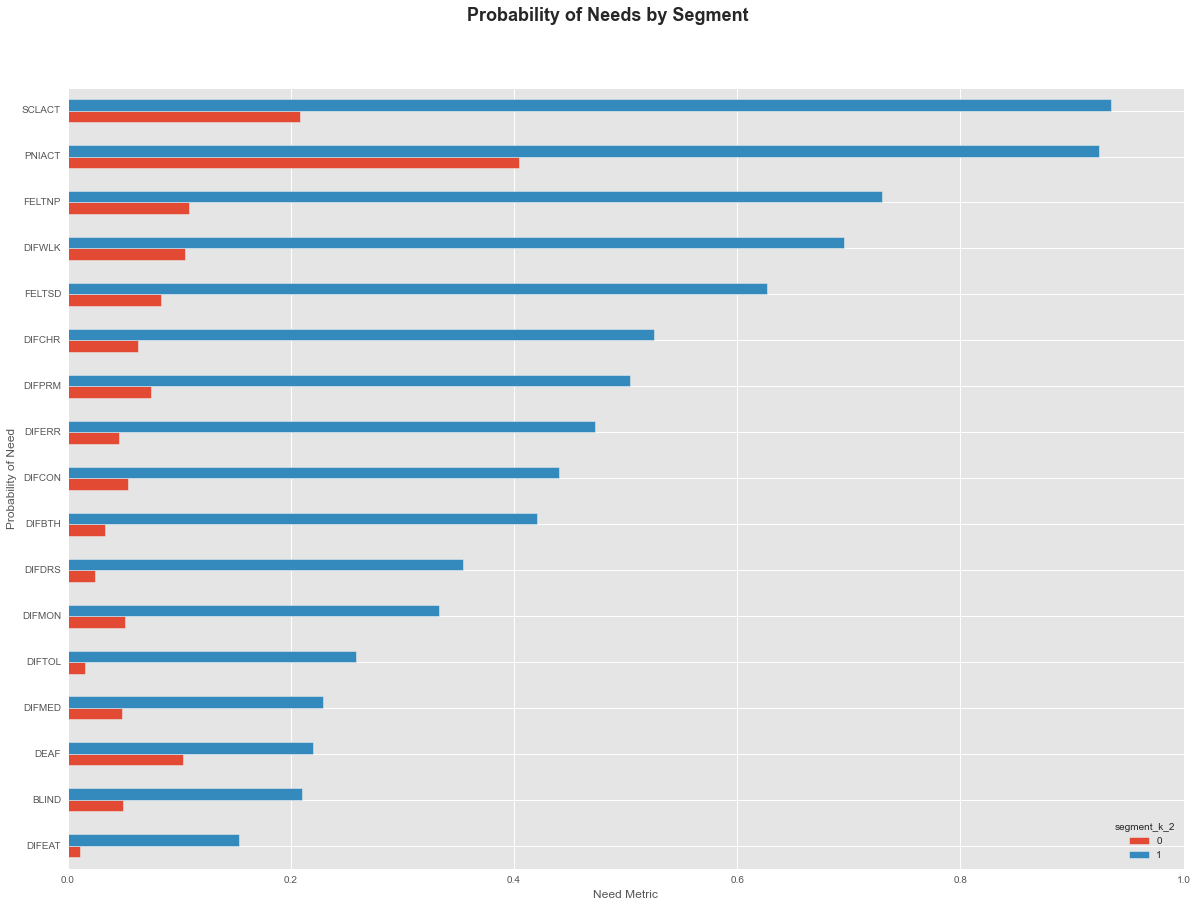

In [96]:
#prob of needs in sort order vertical
fig = plt.figure()
fig.suptitle('Probability of Needs by Segment', fontsize=18, fontweight='bold')

ax = fig.add_subplot(111)
ax.set_xlabel('Need Metric')
ax.set_ylabel('Probability of Need')

needs_cols = list(needs_wellness_seg.columns[0:17])  + ['segment_k_2']
needs_seg = needs_wellness_seg[needs_cols]
chart = pd.pivot_table(needs_seg, index='segment_k_2').transpose().sort(columns=[1]).plot(kind='barh', ax=ax, figsize=(20,14))

In [97]:
#logistic regression/naive bayes + decision trees
#benchmark at better than target.mean
features_array = needs_seg[needs_seg.columns[:-1]].values
target = needs_seg[needs_seg.columns[-1]].values

#train/test split
from sklearn.cross_validation import train_test_split

features_train, features_test, target_train, target_test = train_test_split(
    features_array, target, test_size=0.01, random_state=0)

#build model
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(penalty='l1')
lr.fit(features_train, target_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, penalty='l1', random_state=None, tol=0.0001)

In [98]:
#test model
target_predicted = lr.predict(features_test)

from sklearn.metrics import accuracy_score

print 'Logistic Reg Model: {:.3f}'.format(accuracy_score(target_test, target_predicted))

print 'Baseline Model: {:.3f}'.format(target.mean())

Logistic Reg Model: 0.850
Baseline Model: 0.411


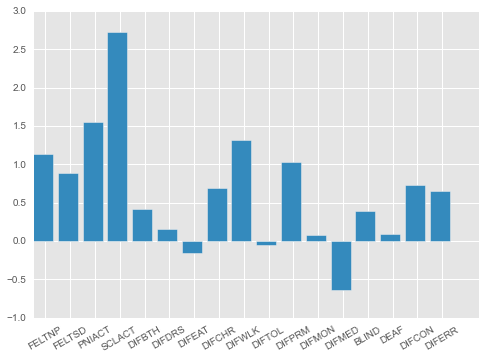

In [99]:
feature_names = needs_seg.columns[:-1].values
feature_names
x = np.arange(len(feature_names))
plt.bar(x, lr.coef_.ravel())
_ = plt.xticks(x + 0.5, feature_names, rotation=30)

Probably don't need test/train split? Want to maximally learn features.  But tried 0.01 and didn't make difference.

Cool.  So we beat the benchmark by 30% and explained an acceptable amount of the variance (90%).  Time to analyze the feature importance for insights.

In [100]:
pd.DataFrame({'Coefficient':lr.coef_.ravel()}, index=feature_names).sort('Coefficient', ascending=False)

Coefficient
SCLACT     2.724982
PNIACT     1.545890
DIFWLK     1.322018
FELTNP     1.135560
DIFPRM     1.034514
FELTSD     0.893270
DIFCON     0.736658
DIFCHR     0.689553
DIFERR     0.648140
DIFBTH     0.418644
BLIND      0.387963
DIFDRS     0.161835
DEAF       0.096940
DIFMON     0.078090
DIFTOL    -0.051379
DIFEAT    -0.149342
DIFMED    -0.642077

Blind and below bias the model to being a 0 or in the  'So-So Segment'.  As suspected, difficulty in social activities, pain in activities difficulty walking and depression indicators overwhelming bias the model to 1 or 'Vulnerable Segment.'

<br> This actually complements the human intuition we get from the sort order bar charts.  Depression indicators, pain and health getting in the way of social activities are strongly correlated with our vulnerable group.

<br> A common technique after factor analysis is to develop a feature-driven label for each segment.  I think this showcases one of the advantages of clustering: ability to build richer personas and humanize the data.  'The Sick and Shut In' are our segment who have mobility trouble and trouble integrating with their social circle because of their poorer health, this is also often accompanied by depression and the 'So So Segment' are less at-risk and probably ignored by the system.  But these individuals do tend to have difficulties with difficulty using toilet without assistance and difficulty taking medication (this is important one as evidence shows that across all health levels/demographics medication adherence is universally a problem).

In [101]:
#radar chart for wellness/dashboard -----   http://bl.ocks.org/chrisrzhou/2421ac6541b68c1680f8
import json

wellness_cols = list(needs_wellness_seg.columns[18:25])  + ['segment_k_2']
wellness_seg = needs_wellness_seg[wellness_cols]

#from https://www.wikiwand.com/en/Feature_scaling
df = needs_wellness_seg[list(needs_wellness_seg.columns[18:25])]
df_norm = (df - df.min()) / (df.max() - df.min())
df_norm['segment_k_2'] = needs_wellness_seg['segment_k_2']

#average values across segments
wellness_avgs = pd.pivot_table(df_norm, index='segment_k_2')

#accept 8 values per segment, label=health domain labels
#list of lists of dicts
legend = ['Vulnerable Segment', 'So-So Segment']
well_vals = wellness_avgs.values

data = []
for segment in well_vals:
    segment_scores = []
    for e, dimension in enumerate(segment):
#         print dimension
        axis_vals = {}
        axis_vals['axis'] = wellness_avgs.columns.values[e]
        axis_vals['value'] = dimension
        segment_scores.append(axis_vals)
    data.append(segment_scores)


with open('radar_data.json', 'w') as outfile:
    json.dump(data, outfile)
# np.max(wellness_seg, axis=0)

###Wellness Gaps

In [1]:
#d3 visualization generation code.  To avoid compatibility issues (d3 manipulates HTML) I will include image below.

# %%html
# <!-- inspired by http://nbremer.blogspot.nl/2013/09/making-d3-radar-chart-look-bit-better.html -->
# <head>
#     <meta http-equiv="Content-Type" content="text/html;charset=utf-8"/>
#     <title>Radar chart</title>
#     <script src="http://d3js.org/d3.v3.min.js"></script>
#     <script src="radar-chart/RadarChart.js"></script>
#     <style>
#         body {
#             overflow: hidden;
#             margin: 0;
#             font-size: 14px;
#             font-family: "Helvetica Neue", Helvetica;
#         }
#         #chart {
#             position: floating;
#         }
#     </style>
# </head>
# <body>
#     <div id="body">
#         <div id="chart"></div>
#     </div>
#     <script src="radar-chart/script.js"></script>
# </body>

<img src=radar-chart/radar-chart-still.png>

Why is there a disconnect here between mental health and depression indicators?  I would investigate this further but will table that, lest we get distracted.  Likely related to survey instrument, reporting behaviors.

In [83]:
wellness_seg.head()

General Health  Vitality  Social Functioning  Physical Functioning  \
ID                                                                              
C16267634               5         5                   3                   2.0   
C16194877               4         2                   4                   0.0   
C16129389               3         4                   0                   0.0   
C14189812               5         6                   4                   2.0   
C16216266               4         6                   1                   1.5   

           Role Physical  Role Emotional  Mental Health  segment_k_2  
ID                                                                    
C16267634            5.0             3.5            3.0            1  
C16194877            1.0             3.0            2.0            0  
C16129389            3.5             2.0            1.0            0  
C14189812            5.0             5.0            4.5            1  
C16216266            2.5             3.5            2.5            1

In [103]:
#logistic regression/naive bayes + decision trees
#benchmark at better than target.mean
features_array = wellness_seg[wellness_seg.columns[:-1]].values
target = wellness_seg[wellness_seg.columns[-1]].values

#train/test split
from sklearn.cross_validation import train_test_split

features_train, features_test, target_train, target_test = train_test_split(
    features_array, target, test_size=0.01, random_state=0)

#build model
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(penalty='l1')
lr.fit(features_train, target_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, penalty='l1', random_state=None, tol=0.0001)

In [104]:
#test model
target_predicted = lr.predict(features_test)

from sklearn.metrics import accuracy_score

print 'Logistic Reg Model: {:.3f}'.format(accuracy_score(target_test, target_predicted))

print 'Baseline Model: {:.3f}'.format(target.mean())

Logistic Reg Model: 0.950
Baseline Model: 0.411


Okay so this is pretty cool.  This model captures 96% of the variance of the data.  (Again no difference in test/train split of .01 and .2)

<br> Also we have to remember to interpret this, wellness scores were inverted to show highlight WELLNESS GAPS.  So for example, the lower your social functioning gap the less likely you are to be in our 'Sick and Shut In' Segment.

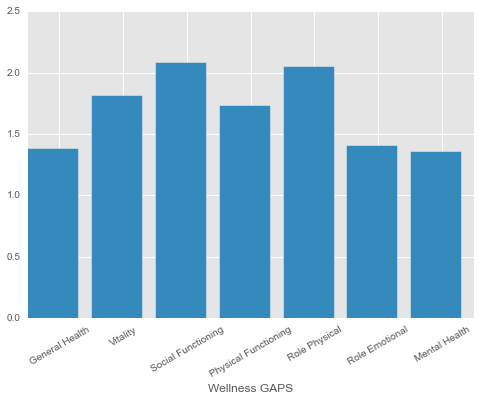

In [105]:
feature_names = wellness_seg.columns[:-1].values
x = np.arange(len(feature_names))
plt.bar(x, lr.coef_.ravel())
_ = plt.xticks(x + 0.5, feature_names, rotation=30)

plt.xlabel('Wellness GAPS')

In [90]:
pd.DataFrame({'Coefficient':lr.coef_.ravel()}, index=feature_names).sort('Coefficient', ascending=False)

Coefficient
Social Functioning       2.086957
Role Physical            2.053376
Vitality                 1.815124
Physical Functioning     1.737777
Role Emotional           1.408242
General Health           1.381125
Mental Health            1.357591

Basically, physical and social functioning predominate here as indicators.  Again we would expect mental health to be there too given high depression indicators in needs.  Therefore, further analysis there might make for some really juicy insights.

##Final Model Evaluation

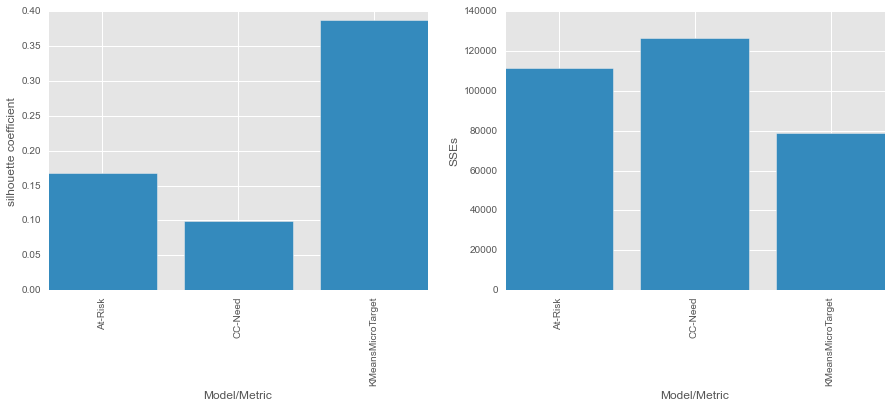

In [136]:
#Plot AtRisk, CC-Need, segment_k_3 against health factors to evaluate
#precision for the three? how many true, true for AtR-seg, CC-seg

#1. SC and SSE on other class labels
X = km_X

#get index from X, retrieve AtR from Profile
AtR_labels = profile.loc[(km_X.index), 'AT-RISK'].values
CC_Need_labels = profile.loc[(km_X.index), 'CC-NEED'].values

def get_scores(X, labels):
    #store SC & SSE scores for each model
    Sil_coef = metrics.silhouette_score(X, labels, metric='euclidean')
    SSE = get_SSE(X, labels)
    return SSE, Sil_coef

AtR_SSE, AtR_Sil_coef = get_scores(X, AtR_labels)
CC_Need_SSE, CC_Need_Sil_coef = get_scores(X, CC_Need_labels)

model_labels = ['At-Risk', 'CC-Need', 'KMeansMicroTarget']
model_Sil_Coefs = [AtR_Sil_coef, CC_Need_Sil_coef, Sil_coefs[0]]
model_SSEs = [AtR_SSE, CC_Need_SSE, SSEs[0]]


fig_compare, (ax1, ax2) = plt.subplots(1,2, figsize=(15,5), sharex=True)

width=0.8
ax1.bar(x1, model_Sil_Coefs, width=width)
ax1.set_xticks(x1 + width/2)
ax1.set_xticklabels(model_labels, rotation=90)
ax1.set_xlabel('Model/Metric')
ax1.set_ylabel('silhouette coefficient')

# # plot here on ax2
ax2.bar(x1, model_SSEs, width=width)
ax2.set_xticks(x1 + width/2)
ax2.set_xticklabels(model_labels, rotation=90)
ax2.set_xlabel('Model/Metric')
ax2.set_ylabel('SSEs')

Our model seems to better represent the underlying structure or "True Groups".  Our model, however, also minimizes the variance between the two segments more than the other standards.  What this ultimately suggests is that if you have limited resources and are looking to focus your capacity on two patient segments, clustering is going to get you maximum the similarity within groups and minimize similarity between them.  My hypothesis is, targeting these populations differently with the additional context provided here will lead to improved quality of care.

##Wrap-Up

#####Segment 1 == 'Sick and Shut In'
- Greater relative % of <65 year olds, non-married individuals, and slighlty more women
- Pain in daily activities, difficulty walking, and trouble integrating with their social circle because of their poorer health, this is also often accompanied by depression.

#####Segment 0 == 'So-So Segment'
- greater relative percentage of **65 to 74 year olds, Whites, and individuals with greater than a HS/GED
-  less at-risk and probably ignored by the system.  But these individuals do tend to have difficulties with difficulty using toilet without assistance and difficulty taking medication.

##Future stuff:

- Develop Personas to share insights with healthcare providers.
- Predictive Modeling to proactively target new beneficiaries.
- Learning more about why social activity is so common and thus an important feature in both segments.
- Breaking analysis down by disease types.

#Thank You!

###Special thanks to GA Teaching Team + Staff.

#Questions?

<img src=https://twistedsifter.files.wordpress.com/2014/07/99th-birthday-for-grandma-funny-tshirt.jpg>